In [1]:
%cd ..

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST


In [2]:
import torch
import pickle
from dataloaders import get_data_loaders
import matplotlib.pyplot as plt
from utils.log import load_checkpoint
from collections import defaultdict
from itertools import islice
from tqdm.notebook import tqdm
from models.Bipartite_Attention_VAE import Bipartite_Attention_VAE as Model
import numpy as np

In [3]:
# α=0.7
config_file_path = 'train_results/biatt-explain/experiment_2023-07-25_22:01:32/config.pkl'
with open(config_file_path, 'rb') as f:
    config = pickle.load(f)

In [4]:
dconfig = config['data']
train_data, val_data, test_data = get_data_loaders(**dconfig)

In [9]:
DEVICE = 'cuda:0'
# α=0.7
checkpoint_file = 'train_results/biatt-explain/experiment_2023-07-25_22:01:32/checkpoints/model_checkpoint_010.pth.tar'
mconfig = config['model']
model = Model(**mconfig)
model = load_checkpoint(checkpoint_file, model)
model = model.to(DEVICE)
model.eval()

Bipartite_Attention_VAE(
  (encoder): Bipartite_Attention(
    (_layers): ModuleList(
      (0): Bipartite_Layers(
        (enc): ModuleList(
          (0): Masked_SAB(
            (mab): Masked_MAB(
              (fc_q): Linear(in_features=50, out_features=128, bias=True)
              (fc_k): Linear(in_features=50, out_features=128, bias=True)
              (fc_v): Linear(in_features=50, out_features=128, bias=True)
              (fc_o): Linear(in_features=128, out_features=128, bias=True)
              (ln0): Masked_LayerNorm(
                (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              )
              (ln1): Masked_LayerNorm(
                (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              )
            )
          )
          (1): Masked_SAB(
            (mab): Masked_MAB(
              (fc_q): Linear(in_features=128, out_features=128, bias=True)
              (fc_k): Linear(in_features=128, out_features=128, bias=True)
       

In [21]:
N_BATCHES = 10
x_origs = []
x_cfs = []
new_masks = []
masks = []
labels = []
for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
    tracks = batch.track_vector.to(DEVICE, torch.float)
    x_origs.append(tracks.detach().cpu().numpy())
    n_tracks = batch.n_tracks.to(DEVICE)
    trig = (batch.trigger.to(DEVICE) == 1).long()
    labels.append(trig.detach().cpu().numpy())

    is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.float).unsqueeze(-1)
    origin_vertices = batch.origin_vertices.to(DEVICE, torch.float)
    ip = batch.ip.to(DEVICE, torch.float).unsqueeze(1).repeat(1, tracks.shape[1], 1)
    ptypes = batch.ptypes.to(DEVICE, torch.float).unsqueeze(-1)
    energies = batch.energies.to(DEVICE, torch.float)
    momentums = batch.momentums.to(DEVICE, torch.float)

    mask = torch.zeros((tracks.shape[0], tracks.shape[1]))
    for i, n_track in enumerate(n_tracks):
        mask[i, :n_track] = 1
    mask = mask.to(DEVICE)
    masks.append(mask.detach().cpu().numpy())


    gt_x = torch.cat([is_trigger_track, origin_vertices, ip, ptypes, energies, momentums], dim=-1)
    x_cf, z_mu, z_logvar, new_mask, z_u_mu, z_u_logvar = model(tracks, gt_x, trig, mask)
    x_cfs.append(x_cf.detach().cpu().numpy())
    new_masks.append(new_mask.detach().cpu().numpy())



  0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cd5f2f760>
Traceback (most recent call last):
  File "/home1/giorgian/anaconda3/envs/trigger/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home1/giorgian/anaconda3/envs/trigger/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home1/giorgian/anaconda3/envs/trigger/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cd5f2f760>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4cd5f2f760>
Traceback (most recent call last):
  File "/home1/giorgian/anaconda3/envs/trigger/lib/python3.10/site-p

if w.is_alive():  File "/home1/giorgian/anaconda3/envs/trigger/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    can only test a child process      File "/home1/giorgian/anaconda3/envs/trigger/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

:     assert self._parent_pid == os.getpid(), 'can only test a child process'
can only test a child process  File "/home1/giorgian/anaconda3/envs/trigger/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError    
assert self._parent_pid == os.getpid(), 'can only test a child process'
: AssertionError
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home1/giorgian/anaconda3/envs/trigger/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
can only test a child process
: AssertionError
AssertionError

In [52]:
def plot_event(batch_idx, event_idx):
    x = x_origs[batch_idx][event_idx][:, :15]
    mask = masks[batch_idx][event_idx]
    x_cf = x_cfs[batch_idx][event_idx]
    new_mask = new_masks[batch_idx][event_idx]
    label = labels[batch_idx][event_idx]
    
    hits = (x * mask[:, None]).reshape(-1, 3)
    good_hits = np.any(hits != 0, axis=-1)
    hits_cf = (x_cf * (new_mask[:, None] > 0.5)).reshape(-1, 3)
    good_hits_cf = np.any(hits_cf != 0, axis=-1)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].scatter(hits[good_hits][:, 0], hits[good_hits][:, 1])
    axes[0].set_title('Original {}'.format('trigger' if label else 'nontrigger'))
    
    axes[1].scatter(hits_cf[good_hits_cf][:, 0], hits_cf[good_hits_cf][:, 1])
    axes[1].set_title('Counterfactual {}'.format('nontrigger' if label else 'trigger'))

    x1, x2 = axes[0].get_xlim(), axes[1].get_xlim()
    xlim = (min(x1[0], x2[0]), max(x1[1], x2[1]))
    axes[0].set_xlim(xlim)
    axes[1].set_xlim(xlim)
    y1, y2 = axes[0].get_ylim(), axes[1].get_ylim()
    ylim = (min(y1[0], y2[0]), max(y1[1], y2[1]))
    axes[0].set_ylim(ylim)
    axes[1].set_ylim(ylim)
    fig.tight_layout()
    
    

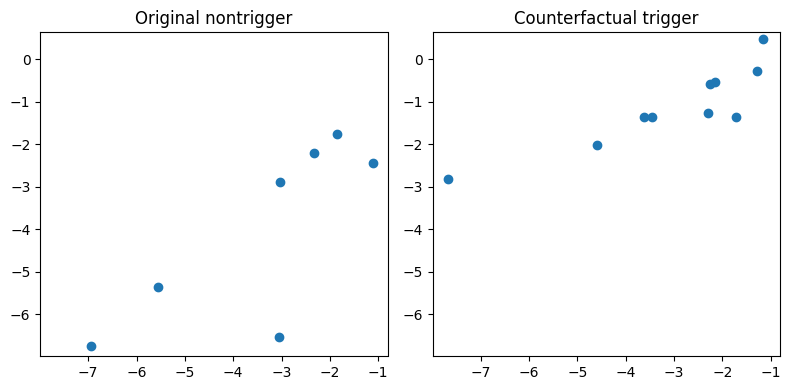

In [76]:
plot_event(0, 8)

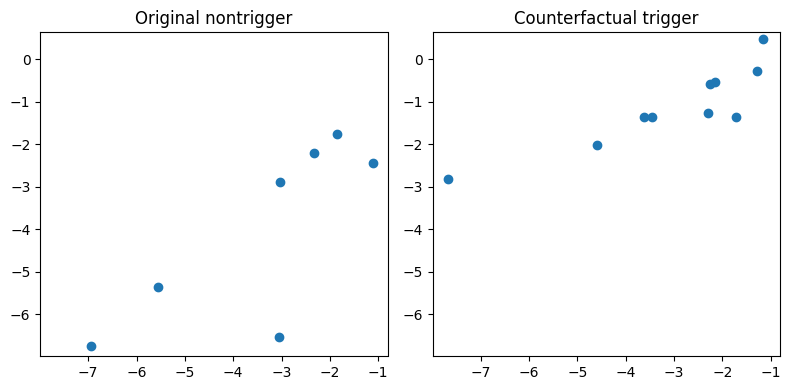

In [70]:
plot_event(0, 8)

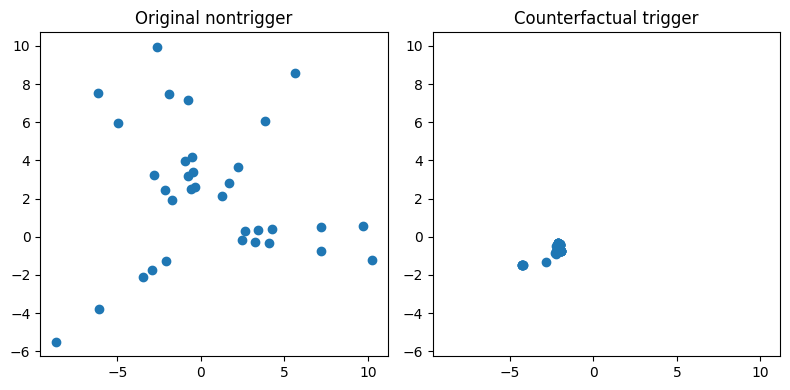

In [68]:
plot_event(0, 14)